In [1]:
import numpy as np
import pickle

# Loading only the 4 GPU data

In [2]:
with open('4gpu.pkl','rb') as f:
    objects_4gpu = pickle.load(f)

/home/coder/miniconda3/envs/alpa-adaptdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-04 10:59:33,777	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
objects_4gpu.t_compilation

{(16, 4, 1): 29.34288183785975,
 (32, 4, 1): 23.39811954088509,
 (64, 4, 1): 25.103760158643126,
 (128, 4, 1): 25.22734735533595,
 (256, 4, 1): 25.943870022892952}

In [4]:
[len(v) for v in objects_4gpu.config_t_iter.values()]

[16, 16, 16, 16, 16]

In [5]:
config_t_iter = {k: np.median(np.sort(v)) for k, v in objects_4gpu.config_t_iter.items()}

In [6]:
X = np.array(list(config_t_iter.keys()))
y = np.array(list(config_t_iter.values()))

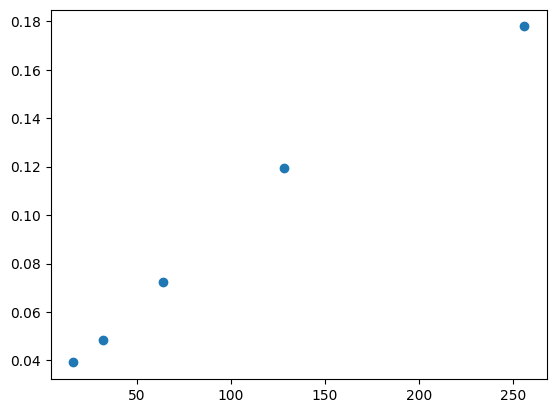

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], y)

In [8]:
all_bs = np.array(list(range(256))).reshape(-1, 1)
gpu4 = np.full(all_bs.shape, 4)
node1 = np.full(all_bs.shape, 1)

all_bs_configs = np.hstack([all_bs, gpu4, node1])

In [9]:
objects_4gpu.predict_t_iter_from_configs(all_bs_configs).shape

(256,)

# Using the regressor from the PolluxAgent object (it has only seen 1 configuration)

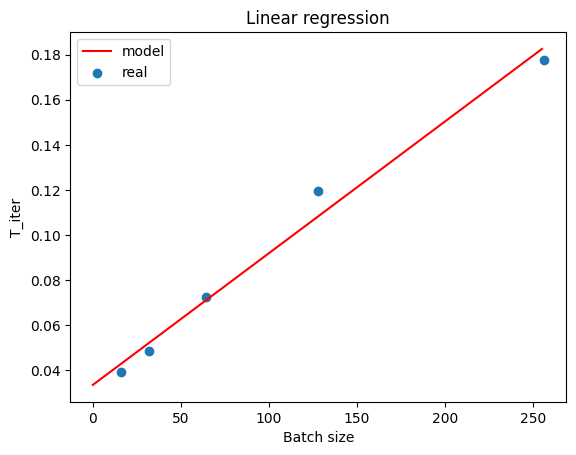

In [10]:
import matplotlib.pyplot as plt

plt.plot(all_bs, objects_4gpu.predict_t_iter_from_configs(all_bs_configs), c="red", label="model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

# Loading and merging 1-2-4 GPU data, then training a new Linear Regressor on them

In [11]:
with open('1gpu.pkl','rb') as f:
    objects_1gpu = pickle.load(f)

with open('2gpu.pkl','rb') as f:
    objects_2gpu = pickle.load(f)

with open('4gpu.pkl','rb') as f:
    objects_4gpu = pickle.load(f)

In [12]:
config_t_iter_1gpu = {k: np.median(np.sort(v)) for k, v in objects_1gpu.config_t_iter.items()}
config_t_iter_2gpu = {k: np.median(np.sort(v)) for k, v in objects_2gpu.config_t_iter.items()}
config_t_iter_4gpu = {k: np.median(np.sort(v)) for k, v in objects_4gpu.config_t_iter.items()}

In [13]:
X_1gpu = np.array(list(config_t_iter_1gpu.keys()))
y_1gpu = np.array(list(config_t_iter_1gpu.values()))

X_2gpu = np.array(list(config_t_iter_2gpu.keys()))
y_2gpu = np.array(list(config_t_iter_2gpu.values()))

X_4gpu = np.array(list(config_t_iter_4gpu.keys()))
y_4gpu = np.array(list(config_t_iter_4gpu.values()))

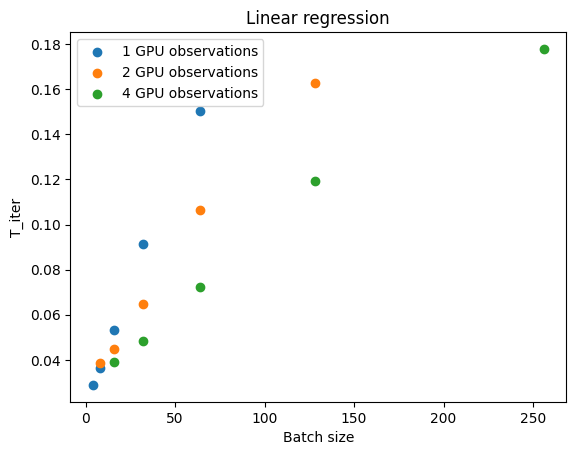

In [14]:
import matplotlib.pyplot as plt

plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU observations")
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU observations")
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU observations")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

In [15]:
X = np.vstack([X_1gpu, X_2gpu, X_4gpu])
y = np.hstack([y_1gpu, y_2gpu, y_4gpu])

In [16]:
X.shape, y.shape

((15, 3), (15,))

In [17]:
all_bs = np.array(list(range(256))).reshape(-1, 1)
gpu1 = np.full(all_bs.shape, 1)
gpu2 = np.full(all_bs.shape, 2)
gpu4 = np.full(all_bs.shape, 4)
node1 = np.full(all_bs.shape, 1)

all_bs_configs_1gpu = np.hstack([all_bs, gpu1, node1])
all_bs_configs_2gpu = np.hstack([all_bs, gpu2, node1])
all_bs_configs_4gpu = np.hstack([all_bs, gpu4, node1])

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

regressor = LinearRegression()
regressor.fit(X, y)

regressor_1gpu = LinearRegression()
regressor_1gpu.fit(X_1gpu, y_1gpu)

regressor_2gpu = LinearRegression()
regressor_2gpu.fit(X_2gpu, y_2gpu)

regressor_4gpu = LinearRegression()
regressor_4gpu.fit(X_4gpu, y_4gpu)

LinearRegression()

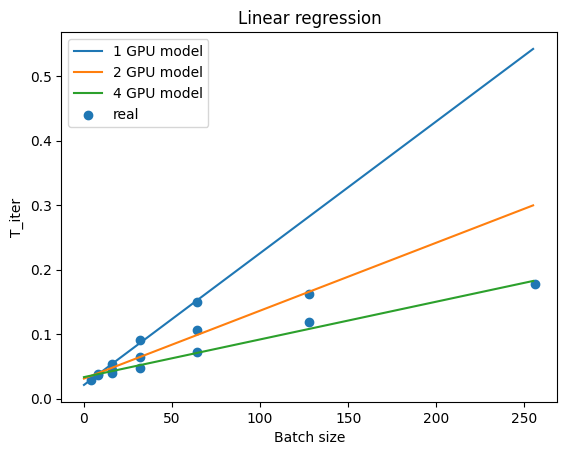

In [19]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor_1gpu.predict(all_bs_configs_1gpu), label="1 GPU model")
plt.plot(all_bs, regressor_2gpu.predict(all_bs_configs_2gpu), label="2 GPU model")
plt.plot(all_bs, regressor_4gpu.predict(all_bs_configs_4gpu), label="4 GPU model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

In [21]:
regressor_1gpu.coef_, regressor_2gpu.coef_, regressor_4gpu.coef_

(array([0.00204317, 0.        , 0.        ]),
 array([0.00105349, 0.        , 0.        ]),
 array([0.00058485, 0.        , 0.        ]))

In [22]:
regressor_1gpu.intercept_, regressor_2gpu.intercept_, regressor_4gpu.intercept_

(0.021346916561014964, 0.03113846810689816, 0.03342748689465225)

### What if batch size (x-axis) is per-GPU batch size (although it is not a thing in Alpa)?

In [141]:
X_1gpu = np.array(list(config_t_iter_1gpu.keys()))
X_1gpu[:,0] = X_1gpu[:,0] / 1
y_1gpu = np.array(list(config_t_iter_1gpu.values()))

X_2gpu = np.array(list(config_t_iter_2gpu.keys()))
X_2gpu[:,0] = X_2gpu[:,0] / 2
y_2gpu = np.array(list(config_t_iter_2gpu.values()))

X_4gpu = np.array(list(config_t_iter_4gpu.keys()))
X_4gpu[:,0] = X_4gpu[:,0] / 4
y_4gpu = np.array(list(config_t_iter_4gpu.values()))

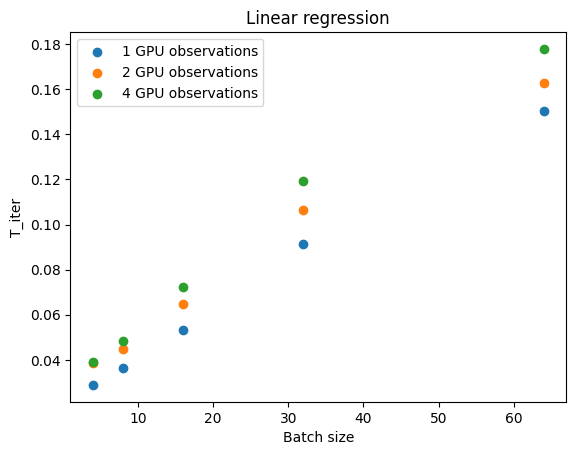

In [136]:
import matplotlib.pyplot as plt

plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU observations")
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU observations")
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU observations")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

In [130]:
X = np.vstack([X_1gpu, X_2gpu, X_4gpu])
y = np.hstack([y_1gpu, y_2gpu, y_4gpu])

In [131]:
all_bs = np.array(list(range(64))).reshape(-1, 1)
gpu1 = np.full(all_bs.shape, 1)
gpu2 = np.full(all_bs.shape, 2)
gpu4 = np.full(all_bs.shape, 4)
node1 = np.full(all_bs.shape, 1)

all_bs_configs_1gpu = np.hstack([all_bs, gpu1, node1])
all_bs_configs_2gpu = np.hstack([all_bs, gpu2, node1])
all_bs_configs_4gpu = np.hstack([all_bs, gpu4, node1])

In [132]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

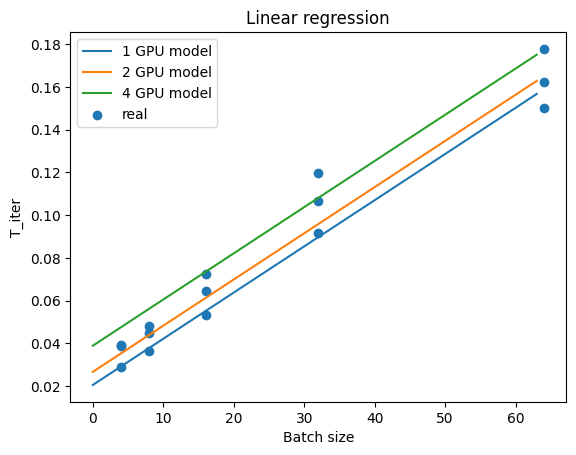

In [133]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor.predict(all_bs_configs_1gpu), label="1 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_2gpu), label="2 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_4gpu), label="4 GPU model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

# Overfitting Gaussian processes regression:

In [116]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, DotProduct, RationalQuadratic

kernel = DotProduct() + RBF() + WhiteKernel(noise_level_bounds=(1e-10, 1e5))
regressor = GaussianProcessRegressor(kernel=kernel)
regressor.fit(X, y)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1))

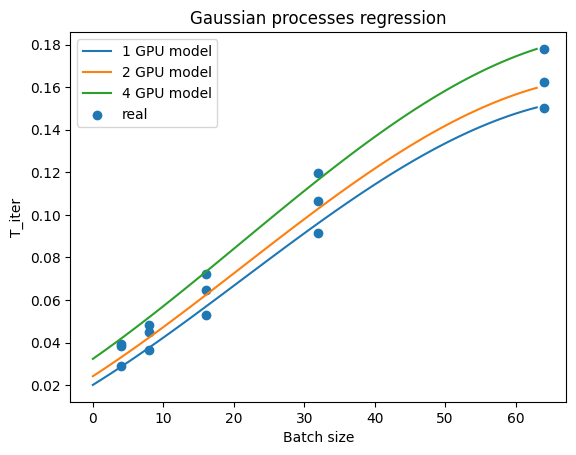

In [117]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor.predict(all_bs_configs_1gpu), label="1 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_2gpu), label="2 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_4gpu), label="4 GPU model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Gaussian processes regression')
plt.legend()